In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='3'

import torch
import numpy as np
import datasets
import pandas as pd
import random
#import umap
import sys
import evaluate
import json
import seaborn as sns
import re
import nltk
import sqlite3
from tabulate import tabulate
from pathlib import Path
from itertools import product
from IPython.core.debugger import set_trace
from datasets import Dataset, DatasetDict, concatenate_datasets
from torch import nn
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from IPython.core.debugger import Pdb, set_trace
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from transformers import AutoModel, AutoTokenizer
from tqdm.notebook import tqdm
#from tqdm import tqdm
from numpy.lib.stride_tricks import sliding_window_view
from pprint import pprint
from scipy.cluster.hierarchy import linkage
from collections import OrderedDict

from nbtools.utils import files, strings

datasets.disable_caching()

cache_dir = '/data/john/cache'
proot = files.project_root()

# Set this to whatever you want
seed = 10

torch.manual_seed(seed)
np.random.seed(seed)

%load_ext autoreload
%autoreload 2
%matplotlib inline

2025-04-11 04:19:10.750875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744363150.767584  189526 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744363150.772739  189526 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-11 04:19:10.790831: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [50]:
cor_pth = '/data/john/projects/nb/data/correlation_data.json'
ds = Dataset.from_json(cor_pth)
ds = ds.filter(lambda x: not x['metric'].startswith('gpt-4o-mini'))
ds = ds.filter(
    lambda x: not (
        x['metric'] == 'cider' 
        or x['metric'] == 'semf1-use'
        or x['metric'] == 'semf1-rob'
    )
)

print(ds)

Filter:   0%|          | 0/576 [00:00<?, ? examples/s]

Filter:   0%|          | 0/576 [00:00<?, ? examples/s]

Dataset({
    features: ['metric', 'function', 'reduction', 'annotator', 'score'],
    num_rows: 468
})


# Create Agreement Matrix for Automatic Evaluation Scores and Annotator Scores

In [88]:
ann_names = [
    'annotator_1', 'annotator_2', 'annotator_3',
    'annotator_agreement',
]

label_map = {
    'annotator_1': r'$A_1$',
    'annotator_2': r'$A_2$',
    'annotator_3': r'$A_3$',
    'annotator_agreement': r'$A_{\text{comb}}$',
    #'semf1-use': r'$\text{S-F1}_{\text{USE}}$',
    #'semf1-distil': r'$\text{S-F1}_{\text{Dist}}$',
    #'semf1-rob': r'$\text{S-F1}_{\text{Rob}}$',
    'semf1-distil': r'$\text{S-F1}$',
    'bertscore': r'$\text{BERTsc}$',
    'rougeLsum': r'$\text{R-L}_{\text{SUM}}$',
    'rougeL': 'R-L',
    'rouge1': 'R-1',
    'rouge2': 'R-2',
    'bleurt': 'BLEURT',
    # 'gpt-4o-coherence': r'$\text{Coh}_{\text{gpt-4o}}$',
    # 'gpt-4o-consistency': r'$\text{Con}_{\text{gpt-4o}}$',
    # 'gpt-4o-fluency': r'$\text{Flu}_{\text{gpt-4o}}$',
    # 'gpt-4o-relevance': r'$\text{Rel}_{\text{gpt-4o}}$',
    'bleu': 'BLEU',
    'meteor': 'METEOR',
    'chrf': 'CHRF',
    'moverscore': 'MoverScore',
    'sms': 'SMS',
    'ter': 'TER',
    #'cider': 'CIDER',
}

pearson_sys = ds.filter(
    lambda x: x['reduction'] == 'system' and x['function'] == 'pearson'
)
kendall_sys = ds.filter(
    lambda x: x['reduction'] == 'system' and x['function'] == 'kendall'
)
pearson_mat = []
kendall_mat = []
met_names = []
for ann in ann_names:
    pearson_mat_row = pearson_sys.filter(
        lambda x: x['annotator'] == ann
    )
    pearson_met_names = pearson_mat_row['metric']
    pearson_mat.append(
        pearson_mat_row['score']
    )

    kendall_mat_row = kendall_sys.filter(
        lambda x: x['annotator'] == ann
    )
    kendall_met_names = kendall_mat_row['metric']
    kendall_mat.append(
        kendall_mat_row['score']
    )
pearson_mat = np.array(pearson_mat)
kendall_mat = np.array(kendall_mat)
met_names = kendall_met_names


row_labels = np.array([label_map.get(ann, ann) for ann in ann_names])
col_labels = np.array([label_map.get(met, met) for met in met_names])


# organize metrics (lexical on left, embedding on right)
pearson_mat = np.hstack((
    pearson_mat[:, 2:6], pearson_mat[:, 7:10], pearson_mat[:, 12:13],
    pearson_mat[:, :2], pearson_mat[:, 6:7], pearson_mat[:, 10:12],
))
kendall_mat = np.hstack((
    kendall_mat[:, 2:6], kendall_mat[:, 7:10], kendall_mat[:, 12:13],
    kendall_mat[:, :2], kendall_mat[:, 6:7], kendall_mat[:, 10:12],
))
col_labels = np.hstack((
    col_labels[2:6], col_labels[7:10], col_labels[12:13],
    col_labels[:2], col_labels[6:7], col_labels[10:12],
))


Filter:   0%|          | 0/468 [00:00<?, ? examples/s]

Filter:   0%|          | 0/468 [00:00<?, ? examples/s]

Filter:   0%|          | 0/52 [00:00<?, ? examples/s]

Filter:   0%|          | 0/52 [00:00<?, ? examples/s]

Filter:   0%|          | 0/52 [00:00<?, ? examples/s]

Filter:   0%|          | 0/52 [00:00<?, ? examples/s]

Filter:   0%|          | 0/52 [00:00<?, ? examples/s]

Filter:   0%|          | 0/52 [00:00<?, ? examples/s]

Filter:   0%|          | 0/52 [00:00<?, ? examples/s]

Filter:   0%|          | 0/52 [00:00<?, ? examples/s]

In [85]:
print(col_labels)
new_col_labels = np.hstack((
    col_labels[2:6], col_labels[7:10], col_labels[12:13],
    col_labels[:2], col_labels[6:7], col_labels[10:12],
))
print(pearson_mat.shape)
print(new_col_labels)
print(len(new_col_labels))


['$\\text{S-F1}$' '$\\text{BERTsc}$' '$\\text{R-L}_{\\text{SUM}}$' 'R-L'
 'R-1' 'R-2' 'BLEURT' 'BLEU' 'METEOR' 'CHRF' 'MoverScore' 'SMS' 'TER']
(4, 13)
['$\\text{R-L}_{\\text{SUM}}$' 'R-L' 'R-1' 'R-2' 'BLEU' 'METEOR' 'CHRF'
 'TER' '$\\text{S-F1}$' '$\\text{BERTsc}$' 'BLEURT' 'MoverScore' 'SMS']
13


Text(0.5, 1.0, "System Level Kendall's $\\tau$ - Annotators vs. Metrics")

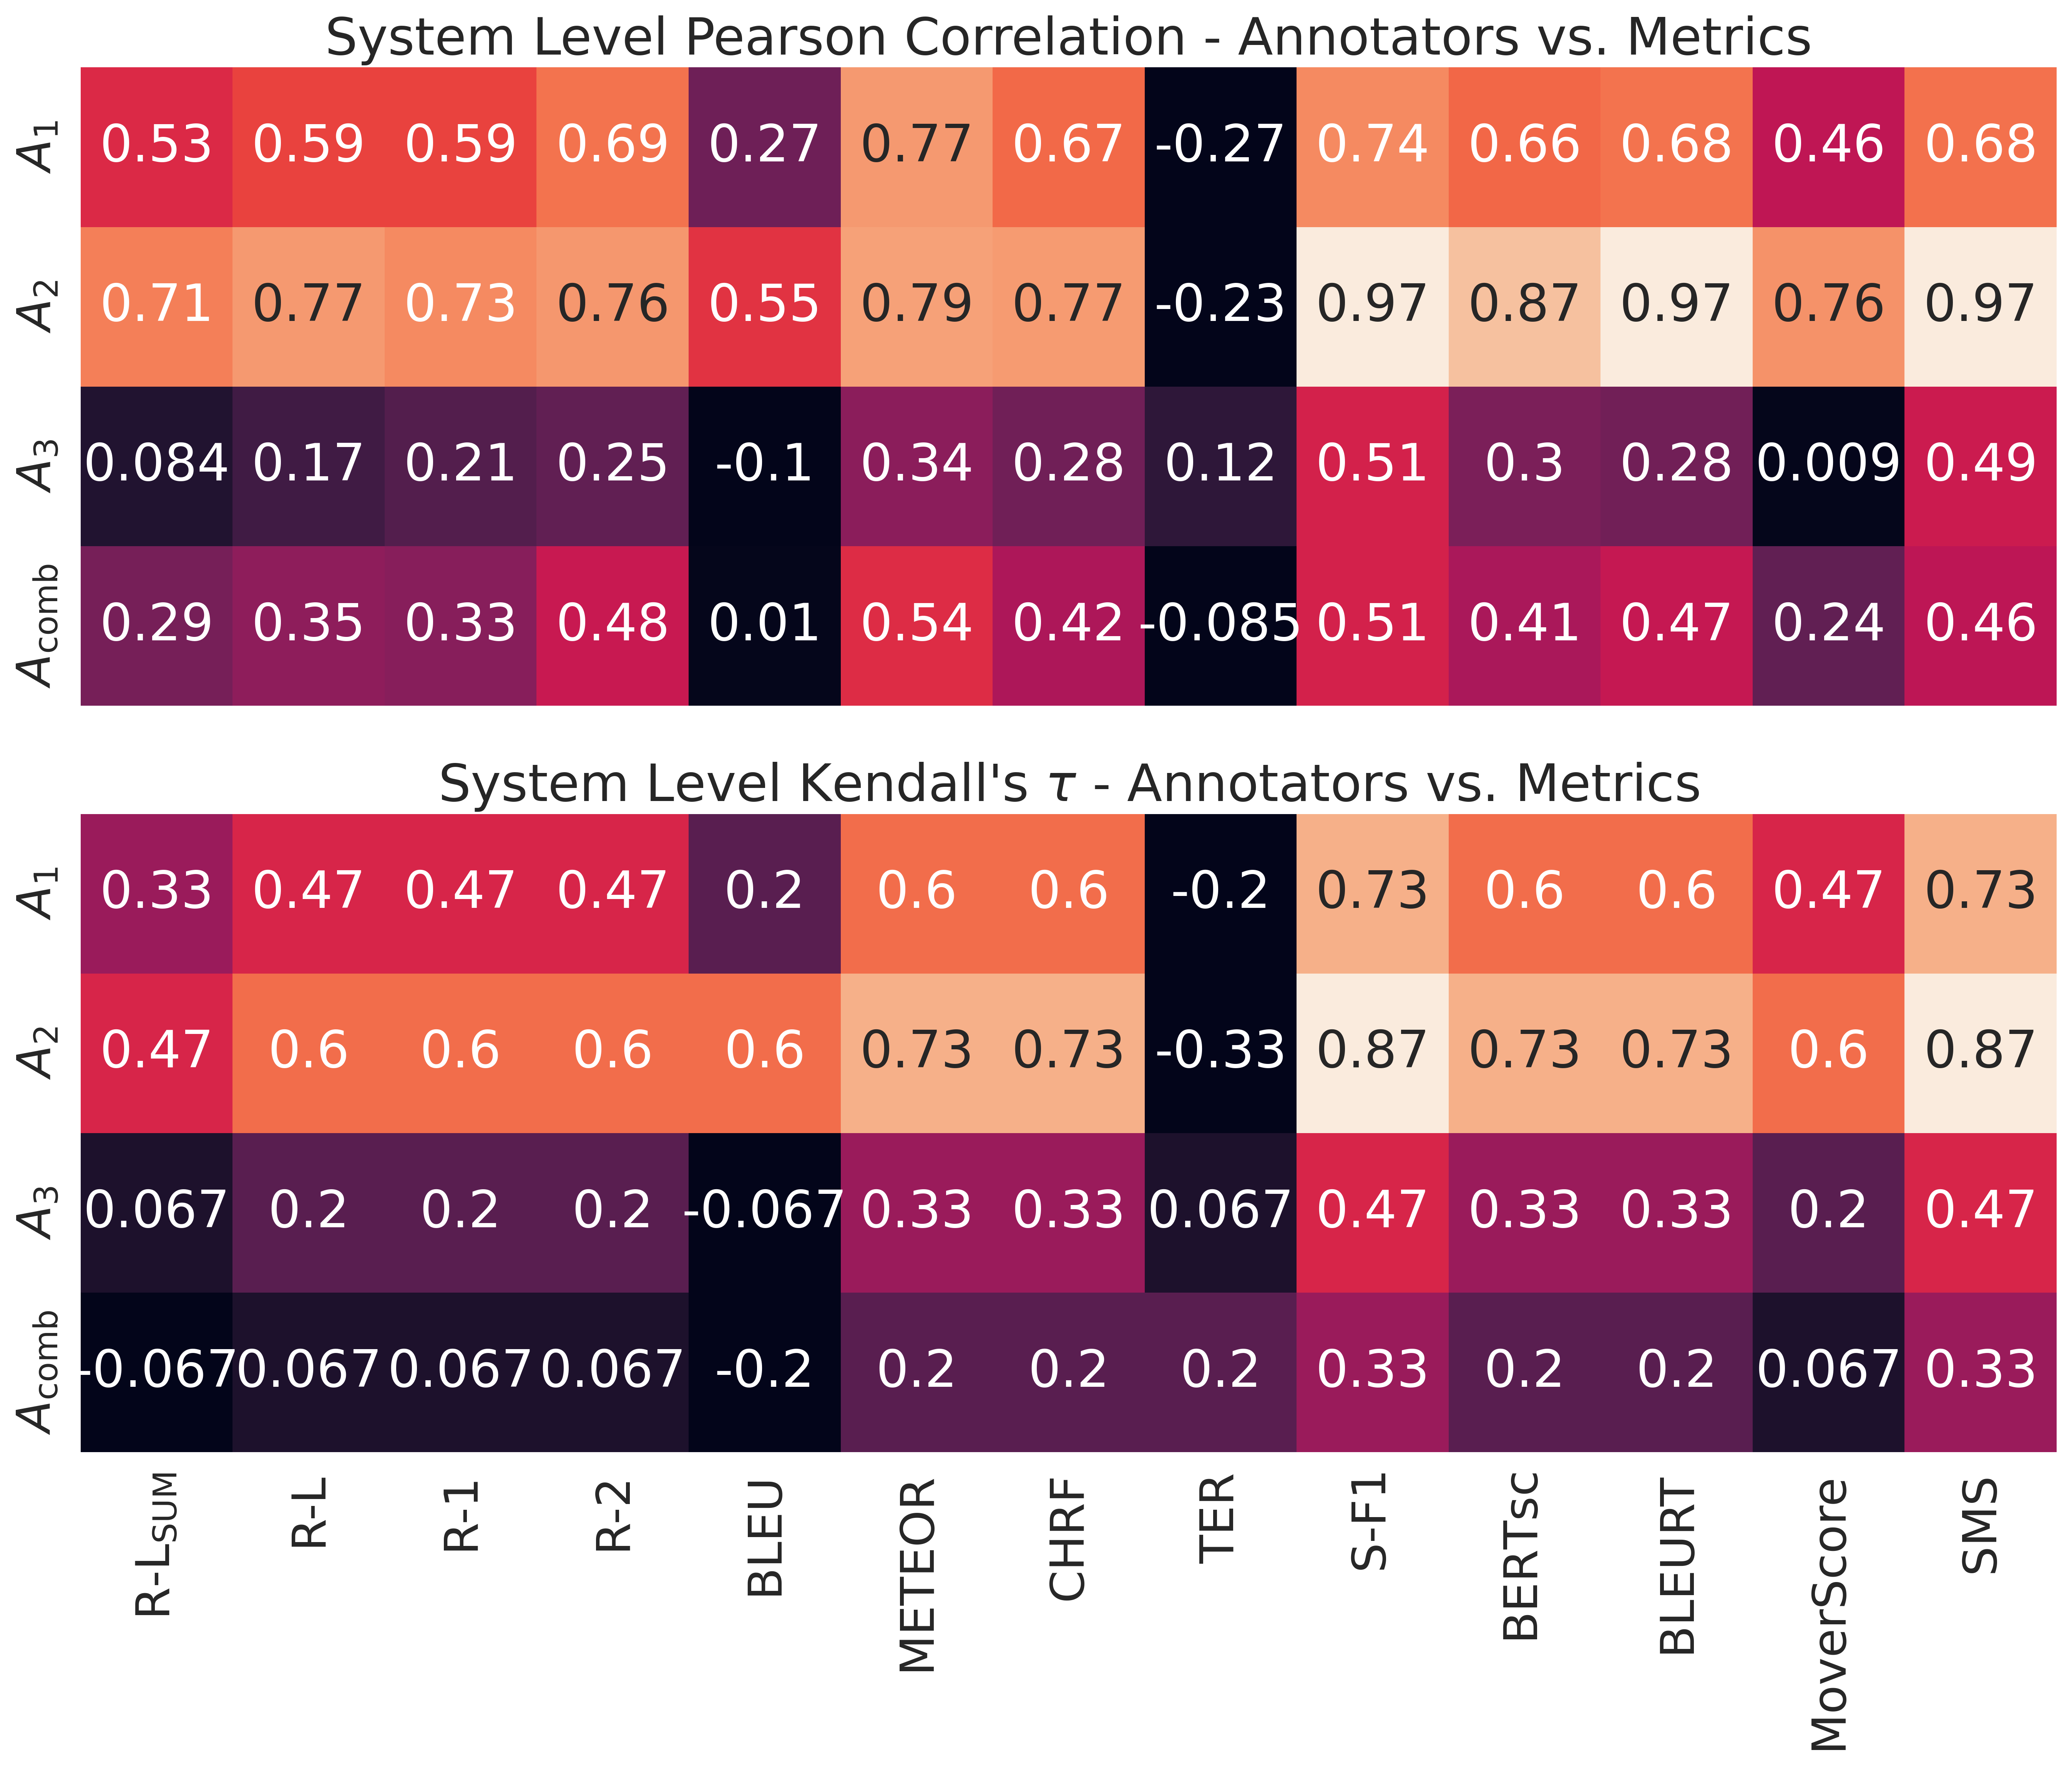

In [89]:
fig, ax = plt.subplots(
    nrows=2,
    sharex=True,
    figsize=(14, 12), dpi=400,
    layout='tight',
)
sns.heatmap(
    pearson_mat, annot=True, vmin=0, cbar=False,
    xticklabels=col_labels, yticklabels=row_labels,
    ax=ax[0]
)
sns.heatmap(
    kendall_mat, annot=True, vmin=0, cbar=False,
    xticklabels=col_labels, yticklabels=row_labels,
    ax=ax[1]
)
ax[0].set_title('System Level Pearson Correlation - Annotators vs. Metrics')
ax[1].set_title(r"System Level Kendall's $\tau$ - Annotators vs. Metrics")

Text(0.5, 1.0, "System Level Kendall's $\\tau$ - Annotators vs. Metrics")

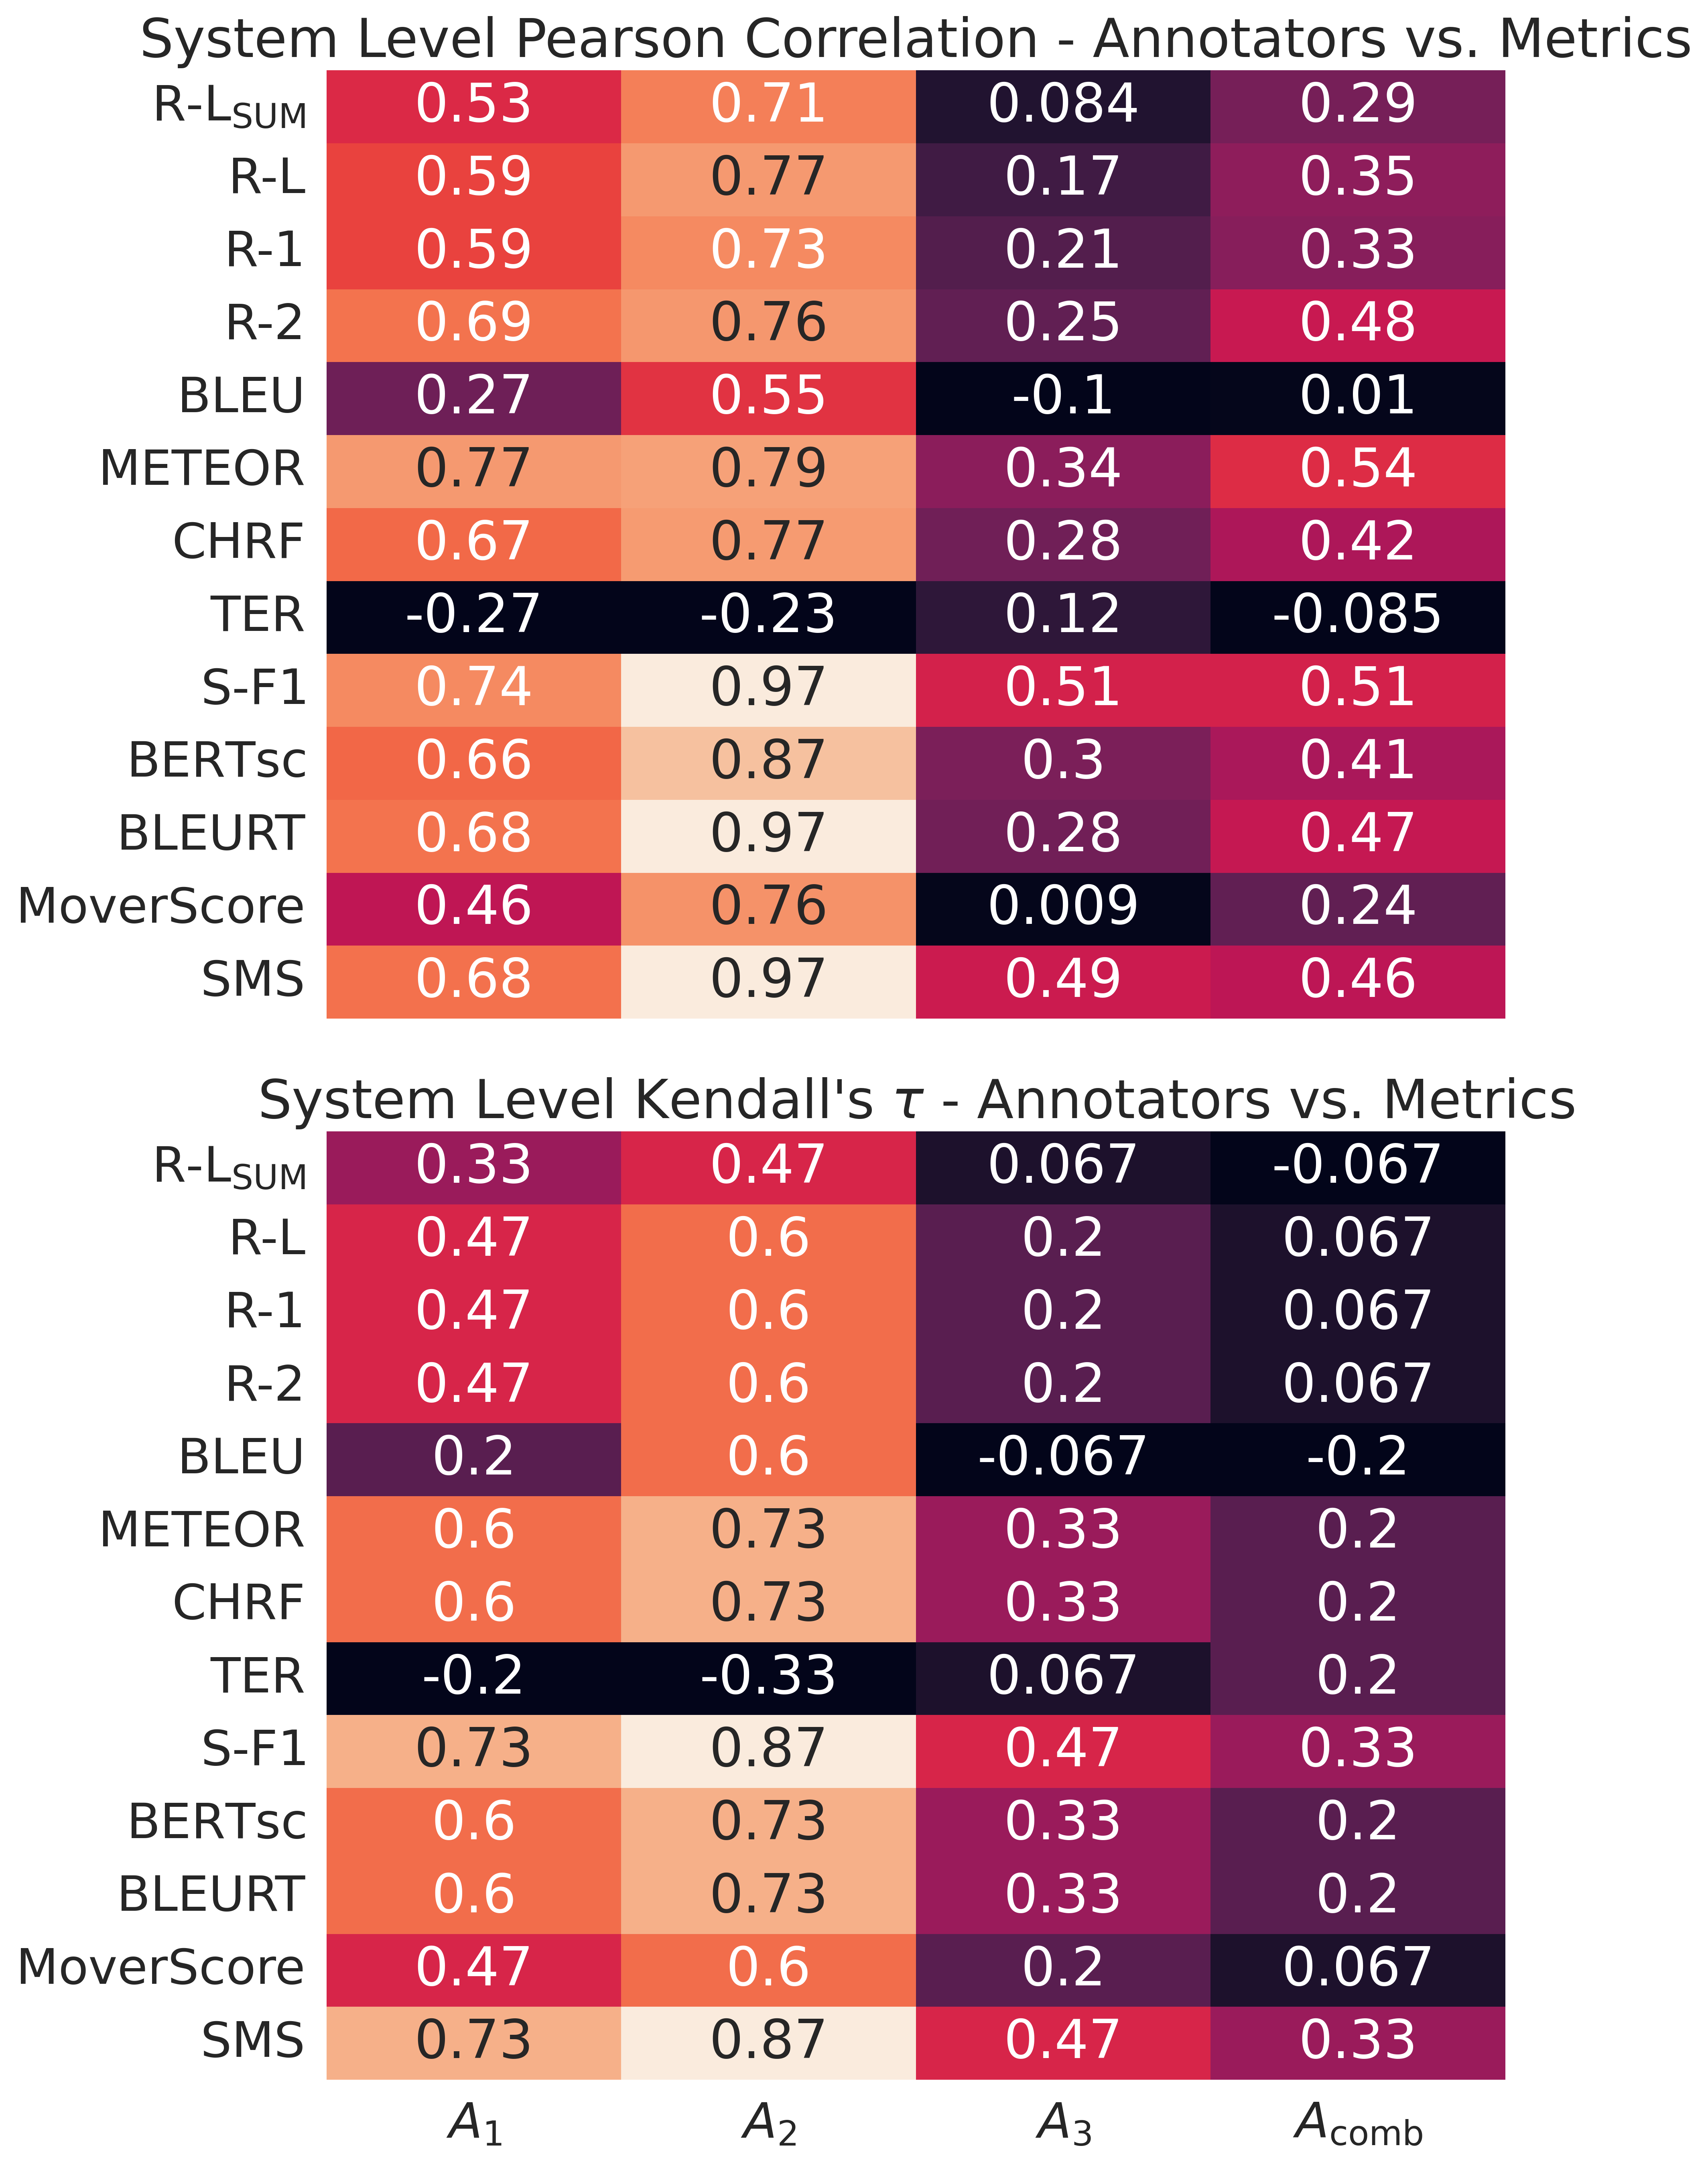

In [90]:
fig, ax = plt.subplots(
    nrows=2,
    sharex=True,
    figsize=(10, 14), dpi=400,
    layout='tight',
)
sns.heatmap(
    pearson_mat.T, annot=True, vmin=0, cbar=False,
    xticklabels=row_labels, yticklabels=col_labels,
    ax=ax[0]
)
sns.heatmap(
    kendall_mat.T, annot=True, vmin=0, cbar=False,
    xticklabels=row_labels, yticklabels=col_labels,
    ax=ax[1]
)
ax[0].set_title('System Level Pearson Correlation - Annotators vs. Metrics')
ax[1].set_title(r"System Level Kendall's $\tau$ - Annotators vs. Metrics")

In [ ]:
sample = ds.filter(
    lambda x: x['function'] == 'kendall' 
        and x['reduction'] == 'system' 
        and x['annotator'] == 'annotator_agreement'
)
print(sample[3])


In [24]:
print(tbl_str)

dataset         model                               metric          average score  template
--------------  ----------------------------------  ------------  ---------------  ----------
all_sides       gemini-pro                          rougeLsum         0.356731     l1
all_sides       gpt-3.5-turbo                       rougeLsum         0.326764     l4
all_sides       lmsys/vicuna-13b-v1.5-16k           rougeLsum         0.278098     l3
all_sides       lmsys/vicuna-13b-v1.5               rougeLsum         0.292308     l3
all_sides       lmsys/vicuna-7b-v1.5-16k            rougeLsum         0.27669      l3
all_sides       lmsys/vicuna-7b-v1.5                rougeLsum         0.288179     l3
all_sides       meta-llama/Llama-2-13b-chat-hf      rougeLsum         0.293698     l1
all_sides       meta-llama/Llama-2-7b-chat-hf       rougeLsum         0.269062     l3
all_sides       microsoft/Phi-3-mini-128k-instruct  rougeLsum         0.315615     l1
all_sides       microsoft/Phi-3-mini-4k-

# Compute Raw Correlation

In [139]:
from scipy.stats import spearmanr, pearsonr, kendalltau

keys = [
    'id', 'template', 'dataset', 'system', 'prompt', 'response', 
    'index', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'semf1-use', 
    'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 
    'sys_text_id', 'prompt_text_id', 'bleu', 'ter', 'meteor', 'chrf', 
    'bleurt', 'sms', 'moverscore',
]

metrics = [
    'rougeLsum', 'rougeL', 'rouge1', 'rouge2', 'bleu', 'meteor', 'chrf', 
    'ter', 'semf1-distil', 'bertscore', 'bleurt', 'moverscore', 'sms', 
]

cor_mat = np.zeros((len(metrics), len(metrics)))

for i, m1 in enumerate(metrics):
    for j, m2 in enumerate(metrics):
        score = pearsonr(
            np.array(all_data[m1]), 
            np.array(all_data[m2])
        ).statistic
        cor_mat[i, j] = score


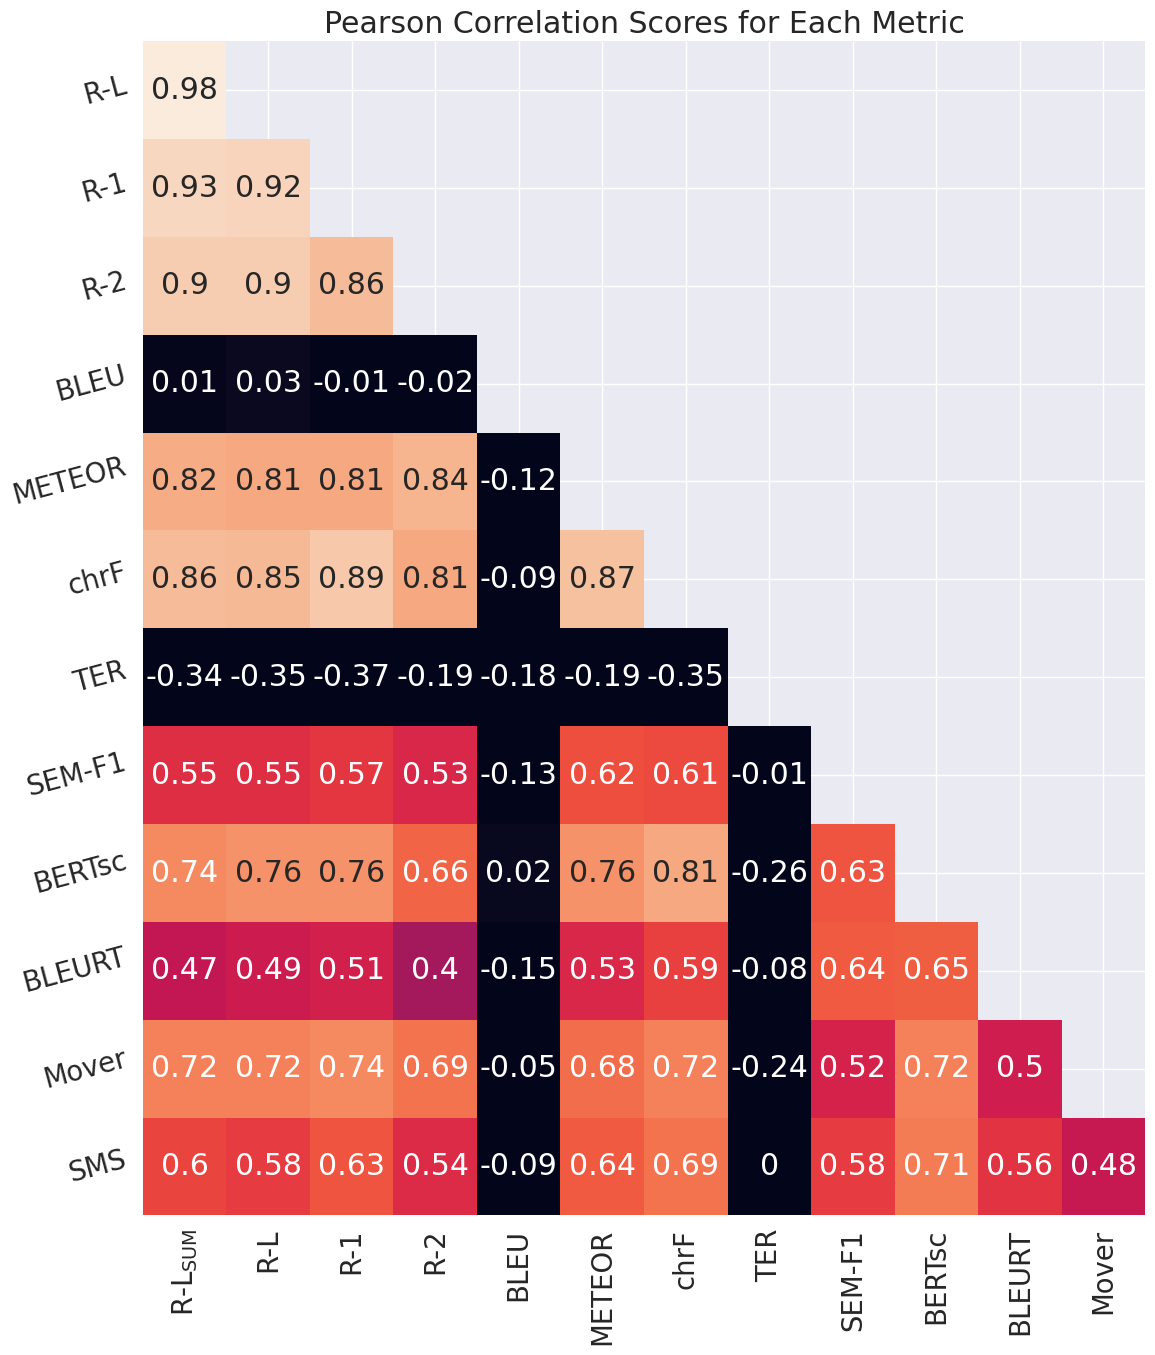

In [162]:
wh = 12.0, 14.0
sns.set_theme(rc={'figure.figsize': wh}, font_scale=1.8)

met_names = [
    r"$\text{R-L}_{\text{SUM}}$", 'R-L', 'R-1', 'R-2', 'BLEU', 'METEOR',
    'chrF', 'TER', 'SEM-F1', 'BERTsc', 'BLEURT', 'Mover', 'SMS'
]

fig, ax = plt.subplots()
sns.heatmap(
    cor_mat[1:, :-1].round(2),
    annot=True,
    vmin=0,
    #xticklabels=metrics[:-1],
    #yticklabels=metrics[1:],
    xticklabels=met_names[:-1],
    yticklabels=met_names[1:],
    mask=np.triu(np.ones(cor_mat[1:, :-1].shape, dtype=bool), k=1),
    cbar=False,
)
plt.title(r"Pearson Correlation Scores for Each Metric")
#ax.tick_params(axis='x', labelrotation=15)
ax.tick_params(axis='y', labelrotation=15)
plt.gcf().subplots_adjust(
    bottom=0.15,
    left=0.15,
)
plt.tight_layout()

In [ ]:
teler_lv, = zip(*cur.execute(f'SELECT DISTINCT(template) from data'))
print(teler_lv)
for lv in teler_lv

['id',
 'template',
 'dataset',
 'system',
 'prompt',
 'response',
 'idx',
 'rouge1',
 'rouge2',
 'rougeL',
 'rougeLsum',
 'semf1_use',
 'semf1_distil',
 'semf1_rob',
 'bertscore',
 'hashcode',
 'model',
 'sys_text_id',
 'prompt_text_id',
 'bleu',
 'ter',
 'meteor',
 'chrf',
 'bleurt',
 'sms',
 'moverscore']
('icl', 'l0', 'l1', 'l2', 'l3', 'l4')


In [163]:
ann_data = Dataset.from_pandas(pd.read_excel(
    f'{files.project_root()}/data/annotation_samples_complete.xlsx'
))
print(ann_data)

Dataset({
    features: ['Column1', 'doc1', 'doc2', 'response', 'id', 'template', 'dataset', 'system', 'prompt', 'index', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2', 'annotator_1', 'annotator_2', 'annotator_3', 'annotator_agreement'],
    num_rows: 630
})


Filter:   0%|          | 0/630 [00:00<?, ? examples/s]

Filter:   0%|          | 0/630 [00:00<?, ? examples/s]

Filter:   0%|          | 0/630 [00:00<?, ? examples/s]

Filter:   0%|          | 0/630 [00:00<?, ? examples/s]

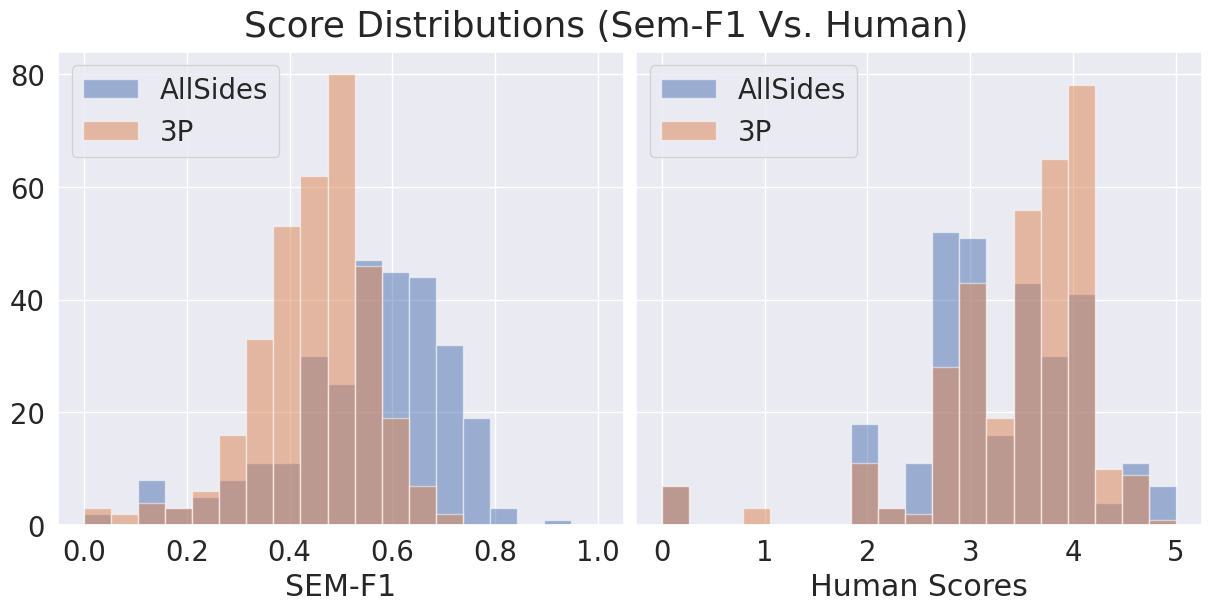

In [175]:
#data = ds
cols = ['semf1-distil', 'annotator_agreement']
label_map = {
    'semf1-distil': 'SEM-F1',
    #'annotator_agreement': r'Ann$_{comb}$',
    'annotator_agreement': 'Human Scores',
}
title_map = {
    'all_sides': 'AllSides',
    'privacy_policy': '3P',
}
bins = {
    'semf1-distil': np.linspace(0, 1, 20),
    'annotator_agreement': np.linspace(0, 5, 20),
}
#col = 'annotator_agreement'

ds_names = ['all_sides', 'privacy_policy']
fig, ax = plt.subplots(
    nrows=1, ncols=2,
    figsize=(12, 6),
    sharey=True,
    layout='constrained',
)
for i, col in enumerate(cols):
    for name in ds_names:
        plt_data = np.array(
            ann_data.filter(lambda x: x[col] is not None and x['dataset'] == name)[col]
        )
        plt_data = plt_data[np.isreal(plt_data)]
        ax[i].hist(
            plt_data,
            bins=bins[col],
            alpha=0.5,
            label=title_map[name],
        )
        ax[i].legend(loc='upper left')
        #ax[i].set_title(label_map[col])
        ax[i].set_xlabel(label_map[col])
fig.suptitle(r'Score Distributions (Sem-F1 Vs. Human)')
plt.savefig('/data/john/score_distribution.png')

# Compute Tables

run `scripts/sos_tables` to generate data

In [3]:
avgs = Dataset.from_json(f"{files.project_root()}/data/avgs_tbl.json")
bests = Dataset.from_json(f"{files.project_root()}/data/bests_tbl.json")
print(avgs)
print(bests)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['dataset', 'metric', 'template', 'score'],
    num_rows: 156
})
Dataset({
    features: ['dataset', 'model', 'metric', 'average score', 'template'],
    num_rows: 416
})


In [9]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 3)

avgs_tbl_pre = {}
avgs_tbl = []
for el in avgs:
    ds_name, metric, template, score = (
        el['dataset'], el['metric'], el['template'], el['score']
    )
    avgs_tbl_pre[ds_name] = avgs_tbl_pre.get(ds_name, {})
    avgs_tbl_pre[ds_name][template] = (
        avgs_tbl_pre[ds_name].get(template, {}) | {
            metric: score,
        }
    )
for ds_name, l1 in avgs_tbl_pre.items():
    for template, l2 in l1.items():
        avgs_tbl.append(
            {'dataset': ds_name,
            'template': template} | l2
        )
print(pd.DataFrame(avgs_tbl))


           dataset template  rougeLsum  rougeL  rouge1  rouge2       bleu  meteor    chrf       ter  semf1_distil  bertscore  bleurt  moverscore    sms
0        all_sides      icl      0.214   0.202   0.286   0.129  9.684e-04   0.342  36.837   942.628         0.423      0.179  -0.768       0.543  0.542
1        all_sides       l0      0.212   0.192   0.279   0.135  8.892e-04   0.337  36.115  1353.976         0.476      0.173  -0.637       0.548  0.546
2        all_sides       l1      0.276   0.258   0.356   0.188  9.892e-04   0.407  42.538   833.364         0.524      0.281  -0.474       0.568  0.561
3        all_sides       l2      0.257   0.243   0.339   0.170  9.677e-04   0.386  40.701   827.023         0.516      0.240  -0.558       0.562  0.549
4        all_sides       l3      0.273   0.263   0.358   0.175  1.211e-03   0.406  42.696   590.499         0.499      0.297  -0.505       0.569  0.565
5        all_sides       l4      0.259   0.250   0.335   0.162  1.492e-03   0.372  39.77

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 3)

bests_tbl_pre = {}
bests_tbl = []

for el in bests:
    ds_name, model, metric, score, template= (
        el['dataset'], el['model'], el['metric'], 
        el['average score'], el['template'],
    )
    bests_tbl_pre[ds_name] = bests_tbl_pre.get(ds_name, {})
    bests_tbl_pre[ds_name][model] = (
        bests_tbl_pre[ds_name].get(template, {}) | {
            metric: f"{score:.3f} ({template})",
        }
    )
for ds_name, l1 in bests_tbl_pre.items():
    for model, l2 in l1.items():
        bests_tbl.append(
            {'dataset': ds_name,
             'model': model} | l2
        )
print(pd.DataFrame(bests_tbl))


           dataset                               model  gemini-pro gpt-3.5-turbo lmsys/vicuna-13b-v1.5-16k lmsys/vicuna-13b-v1.5 lmsys/vicuna-7b-v1.5-16k lmsys/vicuna-7b-v1.5 meta-llama/Llama-2-13b-chat-hf meta-llama/Llama-2-7b-chat-hf microsoft/Phi-3-mini-128k-instruct microsoft/Phi-3-mini-4k-instruct mistralai/Mistral-7B-Instruct-v0.1 mistralai/Mistral-7B-Instruct-v0.2 mosaicml/mpt-30b-chat mosaicml/mpt-30b-instruct mosaicml/mpt-7b-chat mosaicml/mpt-7b-instruct
0        all_sides                          gemini-pro  0.617 (l1)           NaN                       NaN                   NaN                      NaN                  NaN                            NaN                           NaN                                NaN                              NaN                                NaN                                NaN                   NaN                       NaN                  NaN                      NaN
1        all_sides                       gpt-3.5-turbo         N

In [14]:
pprint(bests[:10])

{'average score': [0.4175454712,
                   0.4212362689,
                   0.3263794512,
                   0.3302407409,
                   0.3231219379,
                   0.3546762795,
                   0.3717978395,
                   0.3360202109,
                   0.442380483,
                   0.3750038594],
 'dataset': ['all_sides',
             'all_sides',
             'all_sides',
             'all_sides',
             'all_sides',
             'all_sides',
             'all_sides',
             'all_sides',
             'all_sides',
             'all_sides'],
 'metric': ['rougeLsum',
            'rougeLsum',
            'rougeLsum',
            'rougeLsum',
            'rougeLsum',
            'rougeLsum',
            'rougeLsum',
            'rougeLsum',
            'rougeLsum',
            'rougeLsum'],
 'model': ['gemini-pro',
           'gpt-3.5-turbo',
           'lmsys/vicuna-13b-v1.5-16k',
           'lmsys/vicuna-13b-v1.5',
           'lmsys/vicuna-7b-v